In [3]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.python.keras.models import Model
import tensorflow as tf
import pathlib
from tensorflow.python.keras import layers

Shape of the image (1890,)


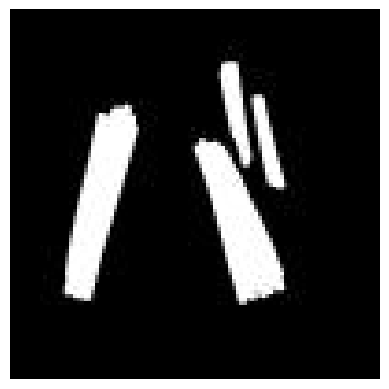

Shape of the image (2268,)


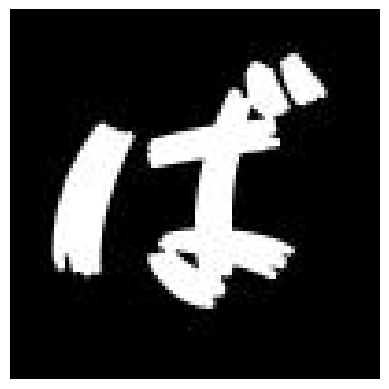

In [4]:
url_kata = r'https://github.com/Orzelius/7500-unique-kana-images/blob/master/katakana/ba_851CHIKARA-DZUYOKU-KANA-A_dakutrue.jpeg?raw=true'
resp = requests.get(url_kata, stream=True).raw
image_array_baKata = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_baKata.shape}')
image_baKata = cv2.imdecode(image_array_baKata, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_baKata, cv2.COLOR_BGR2RGB))
plt.show()

url_hira = r'https://github.com/Orzelius/7500-unique-kana-images/blob/master/hiragana/ba_851CHIKARA-DZUYOKU-KANA-A_dakutrue.jpeg?raw=true'
resp = requests.get(url_hira, stream=True).raw
image_array_baHira = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_baHira.shape}')
image_baHira = cv2.imdecode(image_array_baHira, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_baHira, cv2.COLOR_BGR2RGB))
plt.show()

(40, 40, 3)
(40, 40)


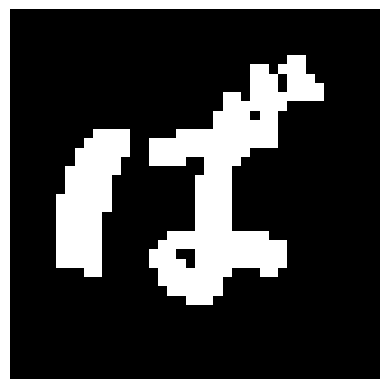

In [5]:
res = cv2.resize(image_baHira , dsize=(40,40), interpolation=cv2.INTER_CUBIC)
print(res.shape)
res = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY) #TO 3D to 1D
print(res.shape)
res = cv2.threshold(res, 127, 255, cv2.THRESH_BINARY)[1]
d = res

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
dataDir = pathlib.Path("dataset/katakanaSeparated/")
validDir = pathlib.Path("dataset/katakanaValidationSeparated/")
print(dataDir)

dataset/katakanaSeparated


In [7]:
batchSize = 32
imgHeight = 100
imgWidth = 100

In [8]:
trainData = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize,
)

validationData = tf.keras.preprocessing.image_dataset_from_directory(
    validDir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize,
)

classNames = validationData.class_names
print(len(classNames))

Found 3376 files belonging to 67 classes.
Using 2701 files for training.
Found 376 files belonging to 67 classes.
Using 75 files for validation.
67


2023-07-12 02:42:10.955179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2701]
	 [[{{node Placeholder/_4}}]]
2023-07-12 02:42:10.955710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2701]
	 [[{{node Placeholder/_4}}]]


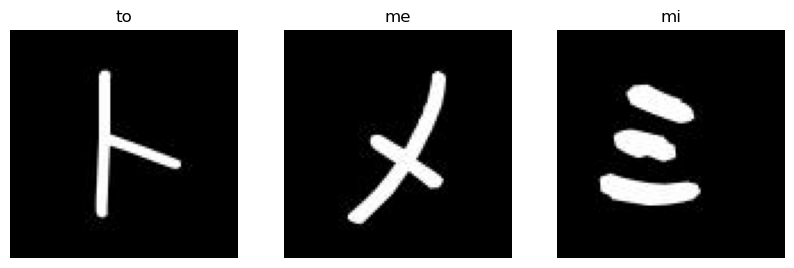

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in trainData.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

In [10]:
numClass = len(classNames)
print(numClass)

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(numClass, activation='softmax')
])

67


In [12]:
model.compile(optimizer='adam',
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
            )

In [31]:
logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                    embeddings_data=trainData
                                                    )

In [32]:
model.fit( 
    trainData,
    validation_data=validationData,
    epochs=20,
    callbacks=[tensorboard_callback]
    )

Layer ModuleWrapper has arguments ['module', 'method_name']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/20


/Users/nabyl/anaconda3/envs/test/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


85/85 [==============================] - 53s 603ms/step - loss: 3.6983 - accuracy: 0.1074 - val_loss: 2.2645 - val_accuracy: 0.3200
Epoch 2/20
85/85 [==============================] - 52s 606ms/step - loss: 1.7327 - accuracy: 0.5139 - val_loss: 1.1793 - val_accuracy: 0.6000
Epoch 3/20
85/85 [==============================] - 50s 590ms/step - loss: 0.8892 - accuracy: 0.7208 - val_loss: 0.7777 - val_accuracy: 0.7733
Epoch 4/20
85/85 [==============================] - 52s 609ms/step - loss: 0.5696 - accuracy: 0.8097 - val_loss: 0.7555 - val_accuracy: 0.7733
Epoch 5/20
85/85 [==============================] - 55s 651ms/step - loss: 0.3950 - accuracy: 0.8619 - val_loss: 0.7419 - val_accuracy: 0.7867
Epoch 6/20
85/85 [==============================] - 58s 680ms/step - loss: 0.2579 - accuracy: 0.9126 - val_loss: 0.6417 - val_accuracy: 0.8267
Epoch 7/20
85/85 [==============================] - 54s 633ms/step - loss: 0.2186 - accuracy: 0.9297 - val_loss: 0.7264 - val_accuracy: 0.7867
Epoch 8/20

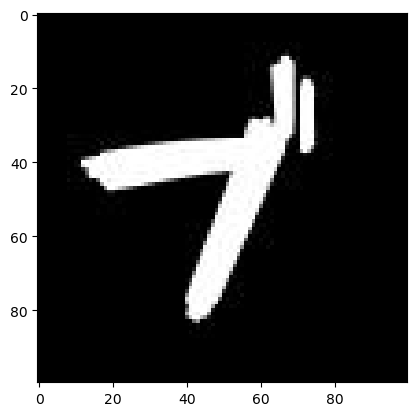

1/1 [==============================] - 0s 35ms/step
bu


In [59]:
image = cv2.imread("dataset/katakanaSeparated/bu/bu_851CHIKARA-DZUYOKU-KANA-A_dakutrue.jpeg",cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

image = np.expand_dims(cv2.resize(image,(100,100)), axis=0)

prediction = model.predict(image) 
classes = np.argmax(prediction,axis=1)

print(classNames[int(classes)])

In [21]:
# Save the weights
#model.save_weights('weights/katakanaWeights')

# Create a new model instance
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(numClass, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
            )

# Restore the weights
model.load_weights('weights/katakanaWeights')

# Evaluate the model
loss, acc = model.evaluate(validationData, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

3/3 [==============================] - 1s 104ms/step - loss: 0.6567 - accuracy: 0.8400
Restored model, accuracy: 84.00%


In [22]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'weights/weights_JS_format/')

NotImplementedError: 
Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config